# ◆Forex forecast USD／JPY
### 目的：為替予測
### 米ドル円の日足にて、売買予測を行う。
- kaggle URL:https://stooq.com/q/d/?s=usdjpy&c=0
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 視覚化

### 3.モデル構築
- 各アルゴリズムのハイパーパラメータ探索を行う。（ロジスティック回帰とSVMを利用）

### 4.モデル評価
- 最良のモデルで汎化性能を算出する。
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「usdjpy_d.csv」

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.dates as mdates
import mpl_finance as mpf
import codecs as cd
import warnings
import mpl_finance
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num = 1000 # ※1以上の場合有効
train_size = 0.7

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))
    
# ============================================================================
# 関数：get_sma
# 引数：終値リスト、期間
# ============================================================================
def get_sma(close, period):
    
    close_mean = close.rolling(period).mean()
    vstack = np.vstack((range(len(close_mean)), close_mean.values.T)).T  # x軸データを整数に
    sma = vstack[:, 1]
    
    return sma

# ============================================================================
# 関数：get_rci
# 引数：終値リスト、期間
# ============================================================================
def get_rci(close, period):
    #時間帯の順位作成
    rank_period = np.arange(period, 0, -1)
    
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        #rciの数合わせ、最初からperiod-1分は0にする
        if i < period - 1:
            rci[i] = 0
        else :
            #価格順位取得             
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            #rci(numpy)を取得
            rci[i] = (1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100
            
    return rci

# ============================================================================
# 関数：傾きを算出
# 引数：終値リスト、期間
# ============================================================================
def get_tilt(close,period):
    
    length = len(close)
    tilt = np.zeros(length)
    
    for i in range(length): # 0～length
        # tiltの数合わせ、最初からperiod-1分は0にする
        if i < period - 1:
            tilt[i] = 0
        else :
            x = np.arange(1,period+1,1)
            y = np.array(pd.Series(close)[i - period + 1: i + 1])
            
            xc = x -x.mean()
            yc = y - y.mean()
            
            xcxc = xc * xc # 分母
            xcyc = xc * yc # 分子
            
            tilt[i] = xcyc.sum()/xcxc.sum()
    return tilt

# ============================================================================
# 学習曲線を作成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    #print('\ntrain_sizes=\n',train_sizes)
    #print('\ntrain_scores_mean=\n',train_scores_mean)
    #print('\ntrain_scores_std=\n',train_scores_std)
    #print('\ntest_scores_mean=\n',test_scores_mean)
    #print('\ntest_scores_std=\n',test_scores_std)
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()


# 1.データ読込

In [2]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

# 計算対象
df = df.query('Date >= "2000-01-01"')

# RCI追加
df['rci9'] = get_rci(df.Close,9)
df['rci21'] = get_rci(df.Close,21)
df['rci52'] = get_rci(df.Close,52)

# RCI傾き
df['tilt_rci9'] = get_rci(df.rci9,9)
df['tilt_rci21'] = get_rci(df.rci21,21)
df['tilt_rci52'] = get_rci(df.rci52,52)

# 終値傾き
df['tilt9'] = get_tilt(df.Close,9)
df['tilt21'] = get_tilt(df.Close,21)
df['tilt52'] = get_tilt(df.Close,52)

# 移動平均線
df['sma5']= get_sma(df.Close,5)
df['sma25']= get_sma(df.Close,25)
df['sma75']= get_sma(df.Close,75)

# 移動平均線の傾き
df['tilt_sma5']= get_tilt(df.sma5,5)
df['tilt_sma25']= get_tilt(df.sma25,25)
df['tilt_sma75']= get_tilt(df.sma75,75)

# ローソク足の長さ
df['day_diff'] = df['High'] - df['Low']

# テスト対象
df = df.query('Date >= "2005-01-01"')

printmd('▼ サイズ')
display(df.shape)

printmd('▼ 直近10行表示')
display(df.tail(10))

printmd('▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))



**▼ サイズ**

(3901, 21)



**▼ 直近10行表示**

,Date,Open,High,Low,Close,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,tilt9,tilt21,tilt52,sma5,sma25,sma75,tilt_sma5,tilt_sma25,tilt_sma75,day_diff
12532,2020-01-06,107.806,108.505,107.774,108.378,-85.000000,-11.688312,21.672501,-99.166667,36.103896,-95.274481,-0.180117,-0.010145,0.007787,108.5020,109.03792,108.593653,-0.21236,0.013937,0.019033,0.731
12533,2020-01-07,108.378,108.628,108.263,108.458,-88.333333,-28.051948,15.534022,-102.500000,11.818182,-95.504994,-0.171150,-0.021935,0.006150,108.4180,108.99804,108.605613,-0.20182,0.012934,0.019605,0.365
12534,2020-01-08,108.459,109.244,107.651,109.078,-58.333333,-35.194805,16.729275,-90.833333,-10.389610,-95.633057,-0.107050,-0.028047,0.005861,108.5128,108.99888,108.626293,-0.12860,0.011869,0.020151,1.593
12535,2020-01-09,109.078,109.582,109.013,109.480,1.666667,-36.753247,19.478357,-32.500000,-30.259740,-95.709895,0.005350,-0.029368,0.006461,108.6990,109.03260,108.657867,-0.00176,0.010917,0.020675,0.569
12536,2020-01-10,109.478,109.688,109.437,109.500,48.333333,-33.766234,24.003244,23.333333,-45.324675,-95.701357,0.108850,-0.028416,0.007732,108.9788,109.05828,108.681440,0.12346,0.010088,0.021177,0.251
12537,2020-01-13,109.538,109.947,109.534,109.934,73.333333,-27.532468,28.707419,58.333333,-57.662338,-95.633057,0.193850,-0.026336,0.009683,109.2900,109.10552,108.709387,0.22100,0.009828,0.021663,0.413
12538,2020-01-14,109.935,110.200,109.862,109.988,90.000000,-8.441558,32.993255,83.333333,-65.584416,-95.445232,0.242017,-0.011927,0.011511,109.5960,109.16264,108.736427,0.27574,0.010074,0.022132,0.338
12539,2020-01-15,109.987,110.001,109.790,109.887,95.000000,2.987013,32.967643,93.333333,-72.077922,-95.197644,0.255800,-0.001694,0.011270,109.7578,109.21504,108.760533,0.27348,0.010595,0.022579,0.211
12540,2020-01-16,109.887,110.186,109.856,110.178,95.000000,22.857143,33.334756,97.500000,-68.181818,-94.864680,0.229350,0.015629,0.011861,109.8974,109.27016,108.792747,0.23050,0.011237,0.023011,0.330
12541,2020-01-17,110.178,110.291,110.051,110.149,93.333333,39.480519,35.682575,92.500000,-49.220779,-94.151797,0.189433,0.030400,0.013141,110.0272,109.33420,108.832533,0.17758,0.012007,0.023430,0.240




**▼ 欠損データ確認**

,Missing num


# 2. データ可視化

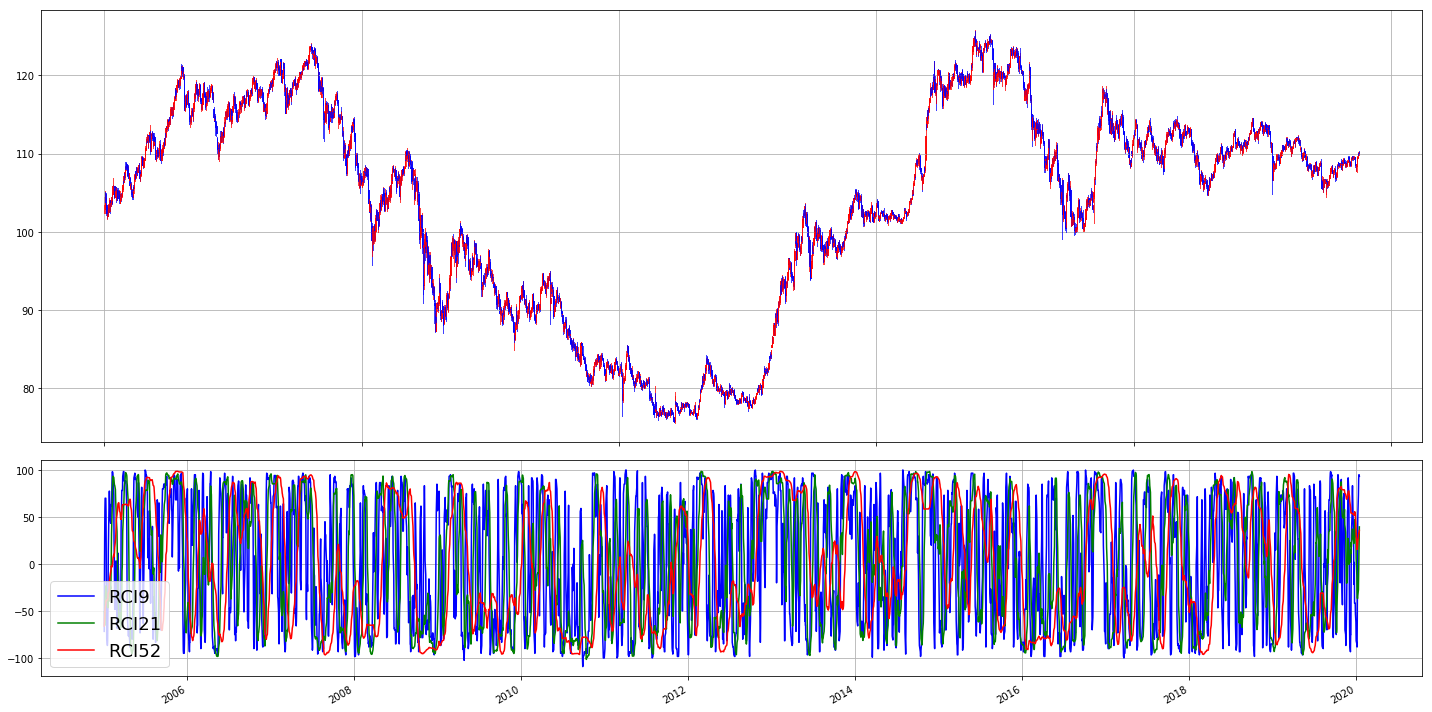

In [3]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

# --------------------------------------------------------------------------
# ローソク足
mpl_finance.candlestick2_ohlc(ax1,opens=df.Open, highs=df.High, lows=df.Low, closes=df.Close, 
                              width=1,colorup='r', colordown='b')
# x軸を時間にする
xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both') #グリッド表示
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
fig.tight_layout()

# --------------------------------------------------------------------------
# テクニカルチャート
ax2.plot(df['Date'], df['rci9'], color='b', antialiased=True, label='RCI9')
ax2.plot(df['Date'], df['rci21'], color='g', antialiased=True, label='RCI21')
ax2.plot(df['Date'], df['rci52'], color='r', antialiased=True, label='RCI52')
ax2.grid(b=True, which='major', axis='both') #グリッド表示

# --------------------------------------------------------------------------

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()


### 翌日終値が当日終値よりも上昇するかを予測する

In [4]:
# 翌日終値 - 当日終値で差分を計算
df['Close_1DayAdd'] = df.Close.shift(-1)
df['Diff'] = df['Close_1DayAdd'] - df['Close']
df = df[:-1]

# 上昇したら「1」、下降したら「0」へデータを変換
mask1 = df['Diff'] >= 0.2   # 上昇した
mask2 = df['Diff'] < 0.2

column_name = 'Diff'
df.loc[mask1, 'Target'] = 1 # 買い
df.loc[mask2, 'Target'] = 0 # 様子見

#df.rename(columns={'Diff' : 'Target'}, inplace=True)




**▼ 目的変数 Targetの種類（%）**

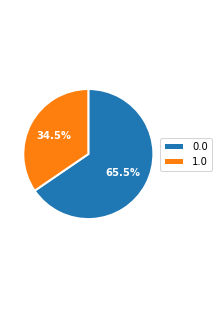

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。




**▼ Targetが成功または失敗のデータを抽出**

,Target
0.0,2553
1.0,1347




**▼ 成功率の平均値**

baseline= 0.3453846153846154


In [5]:
printmd('▼ 目的変数 Targetの種類（%）')
per_state = round(df['Target'].value_counts() / len(df['Target']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

printmd('▼ Targetが成功または失敗のデータを抽出')
display(pd.DataFrame(df['Target'].value_counts(),columns=['Target']))

# 成功率の平均
printmd('▼ 成功率の平均値')
baseline = df['Target'].mean()
print('baseline=',baseline)

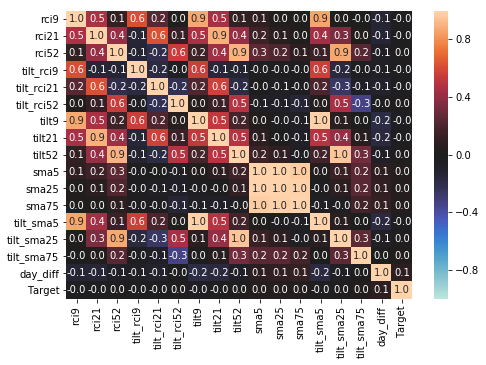

In [6]:
corrmat = df.drop(['Date','Close_1DayAdd','Diff','Open','High','Low','Close'],axis=1).corr()
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corrmat, annot=True, fmt='1.1f', vmax=1, vmin=-1, center=0)

,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,tilt9,tilt21,tilt52,tilt_sma5,tilt_sma25,tilt_sma75,day_diff
12531,-81.666667,6.103896,31.345514,-95.833333,62.597403,-95.052506,-0.172967,0.001806,0.009979,-0.18124,0.014730,0.018433,0.780
12532,-85.000000,-11.688312,21.672501,-99.166667,36.103896,-95.274481,-0.180117,-0.010145,0.007787,-0.21236,0.013937,0.019033,0.731
12533,-88.333333,-28.051948,15.534022,-102.500000,11.818182,-95.504994,-0.171150,-0.021935,0.006150,-0.20182,0.012934,0.019605,0.365
12534,-58.333333,-35.194805,16.729275,-90.833333,-10.389610,-95.633057,-0.107050,-0.028047,0.005861,-0.12860,0.011869,0.020151,1.593
12535,1.666667,-36.753247,19.478357,-32.500000,-30.259740,-95.709895,0.005350,-0.029368,0.006461,-0.00176,0.010917,0.020675,0.569
12536,48.333333,-33.766234,24.003244,23.333333,-45.324675,-95.701357,0.108850,-0.028416,0.007732,0.12346,0.010088,0.021177,0.251
12537,73.333333,-27.532468,28.707419,58.333333,-57.662338,-95.633057,0.193850,-0.026336,0.009683,0.22100,0.009828,0.021663,0.413
12538,90.000000,-8.441558,32.993255,83.333333,-65.584416,-95.445232,0.242017,-0.011927,0.011511,0.27574,0.010074,0.022132,0.338
12539,95.000000,2.987013,32.967643,93.333333,-72.077922,-95.197644,0.255800,-0.001694,0.011270,0.27348,0.010595,0.022579,0.211
12540,95.000000,22.857143,33.334756,97.500000,-68.181818,-94.864680,0.229350,0.015629,0.011861,0.23050,0.011237,0.023011,0.330




**▼標準化**

<Figure size 1440x720 with 0 Axes>

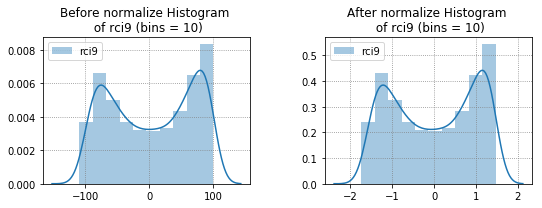

<Figure size 1440x720 with 0 Axes>

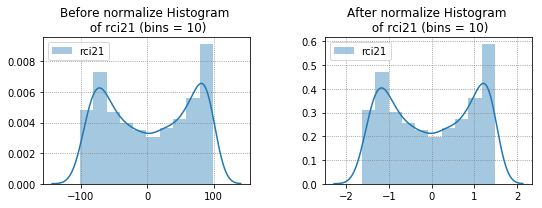

<Figure size 1440x720 with 0 Axes>

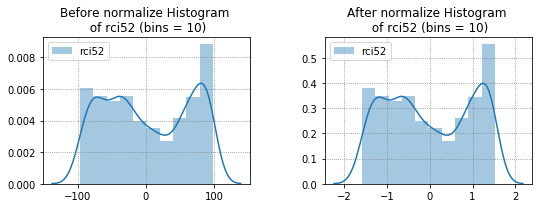

<Figure size 1440x720 with 0 Axes>

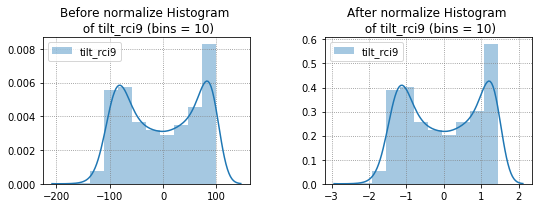

<Figure size 1440x720 with 0 Axes>

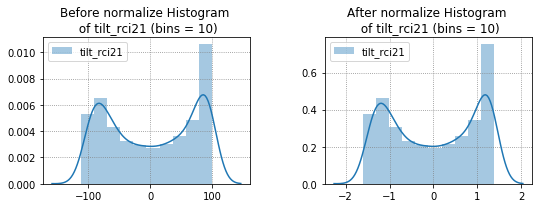

<Figure size 1440x720 with 0 Axes>

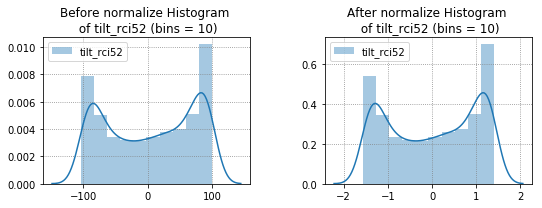

<Figure size 1440x720 with 0 Axes>

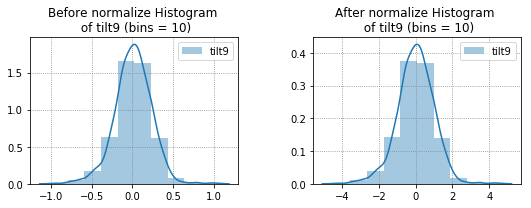

<Figure size 1440x720 with 0 Axes>

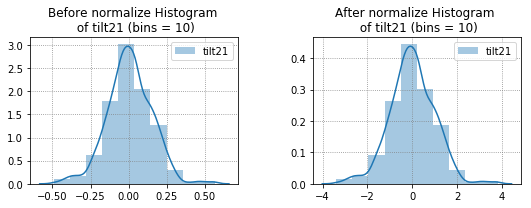

<Figure size 1440x720 with 0 Axes>

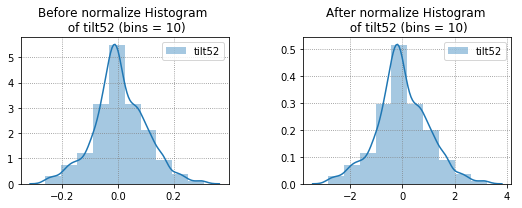

<Figure size 1440x720 with 0 Axes>

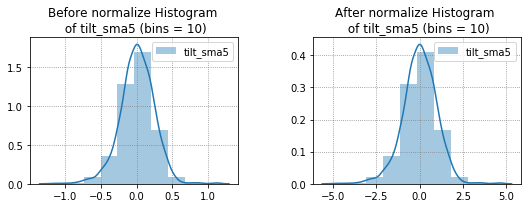

<Figure size 1440x720 with 0 Axes>

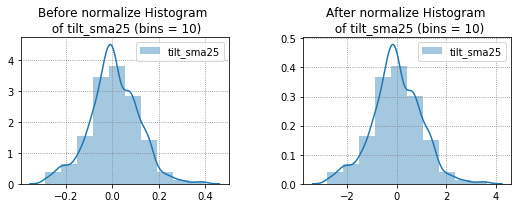

<Figure size 1440x720 with 0 Axes>

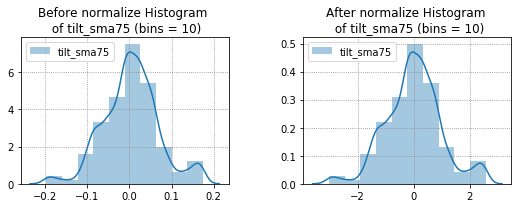

<Figure size 1440x720 with 0 Axes>

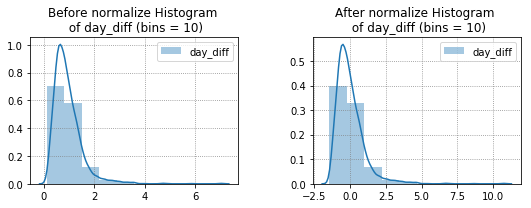

(2730, 13)
(1169, 13)


In [7]:
# データセットの行数、列数を取得
split_row = np.int(train_size * df.shape[0])
X_all_df = df.drop(['Date','Close_1DayAdd','Diff','Target','Open','High','Low','Close','sma5','sma25','sma75'], axis=1)

# 直近の5行を表示
display(X_all_df.tail(10))

# -------------------------------------------------
# 標準化項目リスト
enc_norm_col = ['rci9','rci21','rci52',
                'tilt_rci9','tilt_rci21','tilt_rci52',
                'tilt9','tilt21','tilt52',
                'tilt_sma5','tilt_sma25','tilt_sma75',
               'day_diff']

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, X_all_df.columns.get_loc(col_name))
X_columns = X_all_df.columns
    
# -------------------------------------------------
# ndarrayに変換
X_all = X_all_df.values
y_all = df['Target'].values

X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

X_test = X_all[split_row+1:,:]
y_test = y_all[split_row+1:]

# -------------------------------------------------
printmd('▼標準化')
for col_name,col_idx in dic_norm_col.items():
    plt.subplots_adjust(wspace=8.0, hspace=2.0) # 余白
    plt.figure(figsize=(8,3))
    
    # 標準化前
    plt.subplot(1,2,1)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('Before normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 標準化
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
    #　標準化後
    plt.subplot(1,2,2)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('After normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.tight_layout() # 重ならないように
    plt.show()
    
# 訓練データとテストデータのサイズを確認
print(X_train.shape)
print(X_test.shape)

In [8]:
dic_models = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

In [9]:
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
grid = GridSearchCV(estimator=lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
dic_models.setdefault('LogisticRegression', grid_result) # 辞書に格納
best_lr = grid_result.best_estimator_
# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Score: 0.593407 (0.064743) with: {'alpha': 0.0001, 'penalty': 'none'}
----------------------------------------------
Score: 0.596703 (0.067893) with: {'alpha': 0.0001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.593407 (0.064743) with: {'alpha': 0.0001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.605861 (0.083227) with: {'alpha': 0.0001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.648718 (0.044099) with: {'alpha': 0.001, 'penalty': 'none'}
----------------------------------------------
Score: 0.653114 (0.037883) with: {'alpha': 0.001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.650183 (0.043527) with: {'alpha': 0.001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.644322 (0.034194) with: {'alpha': 0.001, 'penalty': 'elasticnet'}
----------------------------------------------
★BestScore: 0.653114 using {'alpha': 0.001, 'penalty': 'l1'}


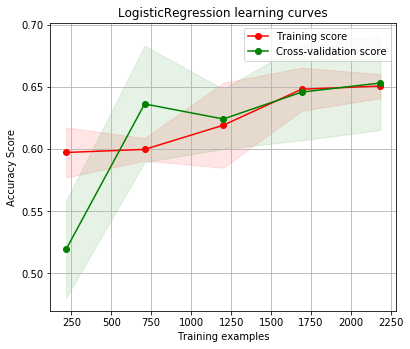

In [10]:
# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)



**▼ 重みを表示（絶対値の降順：Top10）**

,feature,weight
0,tilt_sma25,-0.194619
1,rci9,0.169327
2,tilt9,-0.154135
3,rci52,0.133721
4,tilt52,0.116478
5,tilt_rci52,-0.063343
6,day_diff,0.029228
7,tilt_sma75,0.026639
8,rci21,0.000000
9,tilt_rci9,0.000000




**▼ 重みの大きさを横棒グラフで表示**

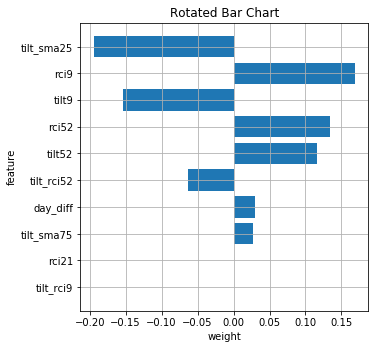



**▼ モデルの評価結果**

正答率（訓練データ） = 65.055%
正答率（テストデータ）= 66.382%
適合率（Precision※精度) = 66.382%
再現率（Recall※検出率) = 100.000%
F1値（F1-score） = 79.794%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,776,0
正解 =翌日上昇する,393,0




**▼ 70%以上の確率でトレードした場合の勝率**

,0,1,2,3,4,5,6,7,8,9,10,11,12,pred,actual,max_prob
70,-1.212402,-0.896469,-1.078808,-0.962926,-1.204928,-1.332792,-0.696892,-0.359087,-1.038351,-0.790885,-0.517537,0.068897,-0.199422,0,0.0,0.703316
71,-1.161335,-1.073789,-1.055944,-1.129338,-1.243350,-1.330428,-0.571837,-0.400798,-0.983971,-0.768606,-0.450533,0.039615,-0.818194,0,1.0,0.710215
72,-0.906002,-1.025429,-1.031991,-1.034245,-1.241521,-1.318608,-0.361450,-0.344563,-0.927355,-0.509512,-0.392115,0.010198,-0.694439,0,0.0,0.707880
73,-0.446403,-0.935762,-0.989053,-0.701423,-1.257987,-1.299198,-0.147385,-0.317711,-0.856458,-0.073012,-0.339735,-0.019264,-1.083381,0,1.0,0.700537
99,-1.416668,0.692359,1.146495,-1.711777,0.235897,1.218252,-0.533585,0.649409,0.693977,-0.583775,0.866527,-0.575434,-1.295532,0,1.0,0.711710
100,-1.340069,0.535189,1.183377,-1.450274,-0.153812,1.261924,-0.471057,0.544262,0.724615,-0.483107,0.910047,-0.581114,-0.659081,0,1.0,0.707786
123,-1.340069,-1.371002,-0.124640,-0.879721,-1.378742,0.680634,-0.623698,-1.033039,-0.086260,-0.608694,-0.264263,-0.363537,-0.646705,0,0.0,0.702445
187,0.089797,-0.963972,-1.289621,1.200422,-0.766735,1.140490,-0.117518,-0.536114,-1.531296,-0.050403,-1.099851,-1.145243,0.069302,0,0.0,0.707934
188,-0.625136,-0.992182,-1.297106,0.701188,-0.986289,1.134020,-0.594126,-0.579114,-1.544550,-0.594419,-0.996197,-1.181775,-0.427483,0,0.0,0.725273
189,-1.161335,-0.992182,-1.303230,-0.154642,-1.089662,1.124937,-1.227789,-0.665095,-1.555930,-1.190997,-0.901782,-1.218070,0.788845,0,0.0,0.720965


正答率（※閾値指定）= 0.5412844036697247


In [11]:

# 学習
best_lr.fit(X_train, y_train)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_all_df.columns)
res_df['weight'] = np.reshape(best_lr.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
printmd('▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
printmd('▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

y_train_pred = best_lr.predict(X_train) # 訓練データ
y_test_pred = best_lr.predict(X_test) # テストデータ


printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])

display(conf_mat)


printmd('▼ 70%以上の確率でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = best_lr.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.70: # 70%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
b = a[a['pred'] != -1]
display(b.head(10))
print('正答率（※閾値指定）=',accuracy_score(b['pred'], b['actual']))